In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np
import scipy.ndimage

# Implementing Brainsim: A Braindrop-like simulation in Nengo

I've had a number of people ask about building an emulator for Braindrop, an analog neuromorphic chip I helped develop https://ieeexplore.ieee.org/document/8591981 .  Doing a "full" emulation is rather difficult, especially since you'd want to be able to adjust the level of detail on the emulation -- during development we created a variety of different emulators at different levels of abstraction, ranging from extremely low-level (nanosecond-scale simulation of individual transistors) to very high-level (just treating all the neurons as LIF and using floating-point multiplies instead of accumulators).

This notebook is an attempt at starting with the highest level of abstraction, and then adding a bit of detail.  The idea here is to show people how to use Nengo to build simulations based around different architectural assumptions, and that this might help people who are making their own chips that will probably have very different assumptions than those made in Braindrop.

## Nengo as a generic neural simulator

The simplest answer for how to use Nengo to implement your particular neuromorphic architecture is to just use Nengo as a normal neural simulator.  You can define your own neuron class (see https://www.nengo.ai/nengo/examples/usage/rectified_linear.html for an example) and you can connect neurons however you want with the Connection class.

However, this is a somewhat unsatisfying answer.  Nengo also has a lot of built-in tools to help build up larger neural systems using separate sub-networks, each of which is optimized locally.  (These tools are known as the Neural Engineering Framework, or NEF). It would be nice to be able to leverage these tools to help build up larger systems.   Furthermore, Braindrop was specifically designed to be suitable for this sort of constructive approach to building systems out of neurons, so it seems like we should be able to make use of that when simulating Braindrop or any other similar system.

## Diffusors and Encoders

One of the basic principles of the NEF (and of Braindrop) is that you don't send inputs to one specific neuron.  Rather, inputs are sent to a group of neurons (an Ensemble), and each neuron reacts to that input slightly differently.  This is inspired by the sorts of population encoding seen in the brain -- many neurons tend to respond to the same inputs, but in differing amounts (i.e. they have different tuning curves).

In Braindrop, this is accomplished using tap-points and diffusors.  Instead of sending an input to a particular neuron, current is injected into particular locations (tap-points) in a resistor mesh (the diffusor).  Each neuron connects to a different point in the resistor mesh.  This means that a neuron close to a tap-point will get a strong input, and those farther away will get weaker inputs.  We define separate tap-points for each input dimension, and we have both positive and negative tap-points, so that a neuron close to a negative tap-point will get a strong input for a large negative value.

Designing this diffusor and characterizing how transistor mismatch affects this current flow (and tweaking it to give good distributions of tuning curves) was a large amount of the engineering effort behind Braindrop.  So for this example, we're just going to make up a simple diffusor that has a square grid, no transistor mismatch, and has a Gaussian current spreading function.  This would definitely have to be much more complicated for a more correct simulator, but the basic principle holds for the more detailed model.

Here's a simple approximation of the diffusor:

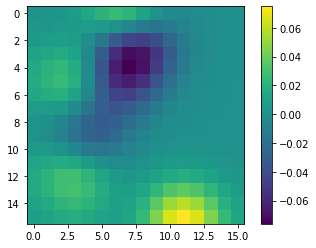

In [2]:
def make_diffusor(shape, n_tap_points, spread, rng):
    mesh = np.zeros(shape)
    np.add.at(mesh, (rng.randint(shape[0], size=n_tap_points), rng.randint(shape[1], size=n_tap_points)), 1)
    np.add.at(mesh, (rng.randint(shape[0], size=n_tap_points), rng.randint(shape[1], size=n_tap_points)), -1)
    mesh = scipy.ndimage.gaussian_filter(mesh, sigma=spread)
    return mesh
    
rng = np.random.RandomState(seed=0)    
plt.imshow(make_diffusor(shape=(16,16), n_tap_points=4, spread=2, rng=rng))
plt.colorbar()
plt.show()

This chooses 4 random positive tap-points and 4 random negative tap-points in a 16x16 ensemble of neurons, and shows how much current each neuron would see given an input of 1.  In a more detailed model including mis-match, we'd also want to be more careful about choosing which tap-points to use in particular.

In general, there can be multiple inputs into the mesh, corresponding to multiple dimensions, so we can just generate multiple versions of this, choosing different tap-points.

Since this characterizes a transformation between the D dimensions of the input and the N neurons, and since this transformation is linear, we can think of this as a set of connection weights between the input and the neurons.  In Nengo and the NEF, this is often called an `encoder` and is one of the basic things that should be specified when defining an Ensemble.

Nengo also allows us to specify a `gain` and a `bias` for each neuron.  In Braindrop, this is set by a combination of transistor mismatch and a few configuration bits per neuron, but here we will just randomly generate these.

You can also, of course, create your own neuron model, as described at https://www.nengo.ai/nengo/examples/usage/rectified_linear.html.  For this example, we'll just use the built-in default LIF neuron model.

Let's try this out making an Ensemble that has 2 input dimensions.

In [3]:
D = 2
shape = (16,16)
N = np.prod(shape)
n_tap_points = 4
spread = 2

# create the encoder
rng = np.random.RandomState(seed=0)   
encoder = np.array([make_diffusor(shape=shape, n_tap_points=n_tap_points, spread=spread, rng=rng).flatten() for i in range(D)])
encoder_gain = np.linalg.norm(encoder, axis=0)
encoder /= encoder_gain[None, :]    # encoders are automatically normalized in nengo

# create the gain and bias
gain = 10+rng.randn(N)
bias = rng.randn(N)

# build the nengo model
import nengo
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=0.5), size_out=D)   # random input
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, encoders=encoder.T,
                         gain=gain, bias=bias)
    nengo.Connection(stim, ens)
    
    p_stim = nengo.Probe(stim)
    p_spikes = nengo.Probe(ens.neurons)

    

You can interact with this model using the Nengo GUI and see the neural activity.  Right-click on the ensemble of neurons and choose 'Firing pattern' to see the neural activity.  Right-click on the stimulus and choose 'Sliders' to let you manually control the inputs.  Press the Play button in the bottom-right to run the simulation.

In [4]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='model.cfg')

We can also manually run the system and plot the results

In [5]:
sim = nengo.Simulator(model)
with sim:
    sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

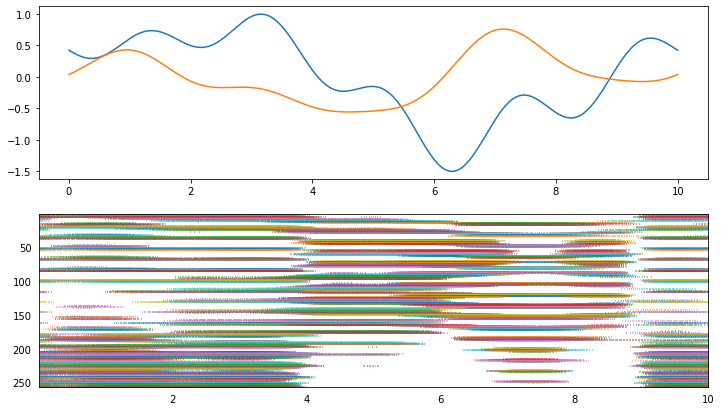

In [6]:
plt.figure(figsize=(12,7))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.subplot(2, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_spikes])

## Computing with neurons

We now have spiking activity that reflects the changing input.  Now let's try to compute something using that input.  For this example, we'll just compute the product between the two values.

To do this, Nengo will compute *decoders*.  These are connection weights that will decode the spikes into some desired output value.  With the addition of the decoders, we now have a standard single-hidden-layer network where the first set of weights are the encoders and the second set of weights are the decoders.  Importantly, we do not have a neural non-linearity at the input or output -- the only neural non-linearities are in the hidden layer.  But we can use this to approximate any function, as single-hidden-layer networks are universal function approximators.

Nengo automatically computes these weights for you when you make a `Connection` out of an `Ensemble`.  In a more detailed simulator, we might constrain these weights by discretizing them or bounding them using a custom `nengo.Solver` class, but we don't do that here.  Instead, we use the default where nengo will automatically feed random inputs into the network, record the resulting firing rates, and then use least-squares minimization to compute the optimal output weights.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

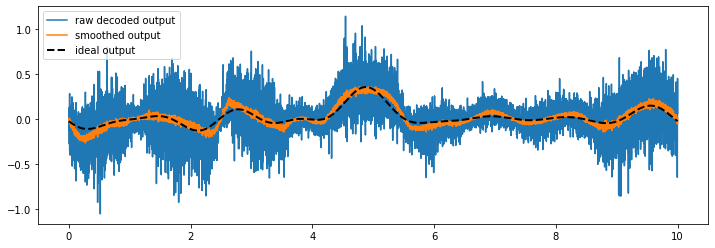

In [14]:
import nengo
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=0.5), size_out=D)
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, encoders=encoder.T,
                         gain=gain, bias=bias)
    nengo.Connection(stim, ens)
    
    output = nengo.Node(None, size_in=1)
    def my_function(x):
        return x[0]*x[1]
    nengo.Connection(ens, output, function=my_function, synapse=None)
    
    p_stim = nengo.Probe(stim)
    p_spikes = nengo.Probe(ens.neurons)
    p_output = nengo.Probe(output)
with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)

    
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_output], label='raw decoded output')
filt = nengo.synapses.Lowpass(0.01)   # for smoothing the output
plt.plot(sim.trange(), filt.filt(sim.data[p_output]), label='smoothed output')
ideal = [my_function(x) for x in sim.data[p_stim]]
plt.plot(sim.trange(), ideal, ls='--', lw=2, label='ideal output', c='k')
plt.legend()
plt.show()


## Building larger systems

Now that we can compute things, we can build larger systems by connecting together multiple Ensembles.  Here, we make three ensembles, two of which will do the same "compute the product" calculation, and a third will compare the two results and see which one is bigger.  That is, the overall system should output a 1 if `a[0]*a[1] >b[0]*b[1]`, and otherwise output a -1.


In [20]:
# define a helper function to make it easier to define an Ensemble
def make_brainsim_ensemble(shape, dimensions, rng, n_tap_points=4, spread=2):
    N = np.prod(shape)
    encoder = np.array([make_diffusor(shape=shape, n_tap_points=n_tap_points, spread=spread, rng=rng).flatten() for i in range(dimensions)])
    encoder_gain = np.linalg.norm(encoder, axis=0)
    encoder /= encoder_gain[None, :]

    gain = 10+rng.randn(N)
    bias = rng.randn(N)
    
    ens = nengo.Ensemble(n_neurons=N, dimensions=dimensions, encoders=encoder.T,
                         gain=gain, bias=bias)    
    return ens

rng = np.random.RandomState(seed=3)   
model = nengo.Network()
with model:
    stim_a = nengo.Node(nengo.processes.WhiteSignal(period=10, high=0.5), size_out=2)
    a = make_brainsim_ensemble((16,16), dimensions=2, rng=rng)
    nengo.Connection(stim_a, a)
    
    stim_b = nengo.Node(nengo.processes.WhiteSignal(period=10, high=0.5), size_out=2)
    b = make_brainsim_ensemble((16,16), dimensions=2, rng=rng)
    nengo.Connection(stim_b, b)
    
    compare = make_brainsim_ensemble((16,16), dimensions=1, rng=rng)
    nengo.Connection(a, compare, function=lambda x: x[0]*x[1])
    nengo.Connection(b, compare, function=lambda x: x[0]*x[1], transform=-1)
    
    output = nengo.Node(None, size_in=1)
    nengo.Connection(compare, output, function=lambda x: 1 if x>0 else -1)
    
    p_stim_a = nengo.Probe(stim_a)
    p_stim_b = nengo.Probe(stim_b)
    p_output = nengo.Probe(output)
    
sim = nengo.Simulator(model, seed=3)
with sim:
    sim.run(10)
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

And now we can see the results.

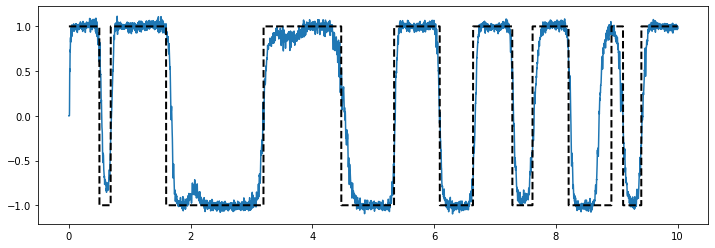

In [21]:
plt.figure(figsize=(12,4))
filt = nengo.synapses.Lowpass(0.01)
plt.plot(sim.trange(), filt.filt(sim.data[p_output]))

ideal = np.where(sim.data[p_stim_a][:,0]*sim.data[p_stim_a][:,1]>sim.data[p_stim_b][:,0]*sim.data[p_stim_b][:,1], 1, -1)
plt.plot(sim.trange(), ideal, ls='--', lw=2, c='k')
plt.show()

The neurons are doing a decent job of computing the function.  This could be further optimized by having better distributions of gains and biases in the neurons, or by better placement of tap-points.

## Adding Implementation Details: The Accumulator

The above code gives a basic simulation of a Braindrop-like system.  However, there is one important component of Braindrop that should be added.  In particular, so far we have assumed inputs and outputs are continuus values.  In Braindrop, inputs and outputs are all spikes and they are generated by an Accumulator.  Please see the Braindrop paper for more details about this approach, but since it is so important we should implement it in our Nengo version.

To do this, we implement a `nengo.Process`, which is how we implement arbitrary code in Nengo.  For this accumulator, we just implement it with floating-point math (in Braindrop, this is done with 8-bit fixed-point).

For any accumulator, we must specify its maximum frequency (`fmax`).  This is the number of spikes per second that it will generate given an input of 1.  Here, we pick 1000.

(Note that this implementation does allow the accumulator to spike multiple times per timestep.  This is because this simulation will be run on a computer with some timestep (the default in Nengo is `dt=0.001` seconds.  But the actual hardware doesn't have a timestep as it is all event-driven, so it's perfectly capable of generating multiple spikes per timestep.)




In [32]:
class Accumulator(nengo.Process):
    def __init__(self, size_in, fmax=1000):
        self.fmax = fmax
        super().__init__(default_size_in=size_in, default_size_out=size_in)
        
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state=np.zeros(shape_in)
        
        # this code will be run each time step
        def step_accumulator(t, x, state=state):
            state += x*(self.fmax*dt)   # build up the accumulator
            spikes = np.round(state)    # emit positive and negative spikes
            state -= spikes
            return spikes/(dt*self.fmax)    # scale output by fmax
        return step_accumulator 
    
model = nengo.Network()
with model:
    stim = nengo.Node(np.sin)
    acc = nengo.Node(Accumulator(fmax=1000, size_in=1))
    nengo.Connection(stim, acc, synapse=None)
    
    p_stim = nengo.Probe(stim)
    p = nengo.Probe(acc)
sim = nengo.Simulator(model, dt=0.001)
with sim:
    sim.run(6)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

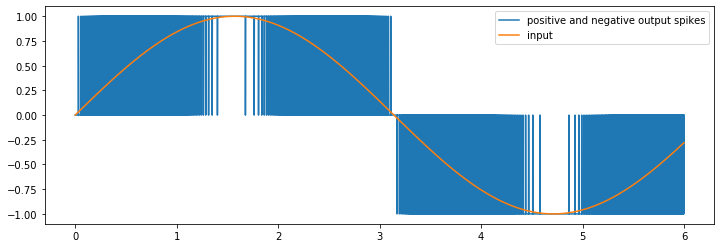

In [37]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p], label='positive and negative output spikes')
plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.legend()
plt.show()

Given these Accumulators, we can build the above model again, but this time interspersing Accumulators in the places where they would exist in the hardware.

We also take this opportunity to also correctly place the low-pass filter synapse.  In Braindrop, this occurs after the accumulator and before the diffusor, so we use nengo to add a `synapse` that is a low-pass filter to that Connection.

In [29]:
rng = np.random.RandomState(seed=3)   
model = nengo.Network()
with model:
    stim_a = nengo.Node(nengo.processes.WhiteSignal(period=10, high=0.5), size_out=2)
    acc_a = nengo.Node(Accumulator(size_in=2))
    a = make_brainsim_ensemble((16,16), dimensions=2, rng=rng)
    nengo.Connection(stim_a, acc_a, synapse=None)
    nengo.Connection(acc_a, a, synapse=nengo.synapses.Lowpass(0.01))
    
    stim_b = nengo.Node(nengo.processes.WhiteSignal(period=10, high=0.5), size_out=2)
    acc_b = nengo.Node(Accumulator(size_in=2))
    b = make_brainsim_ensemble((16,16), dimensions=2, rng=rng)
    nengo.Connection(stim_b, acc_b, synapse=None)
    nengo.Connection(acc_b, b, synapse=nengo.synapses.Lowpass(0.01))
    
    compare = make_brainsim_ensemble((16,16), dimensions=1, rng=rng)
    acc_compare = nengo.Node(Accumulator(size_in=1))
    nengo.Connection(a, acc_compare, function=lambda x: x[0]*x[1], synapse=None)
    nengo.Connection(b, acc_compare, function=lambda x: x[0]*x[1], transform=-1, synapse=None)
    nengo.Connection(acc_compare, compare, synapse=nengo.synapses.Lowpass(0.01))
    
    output = nengo.Node(Accumulator(size_in=1))
    nengo.Connection(compare, output, function=lambda x: 1 if x>0 else -1, synapse=None)
    
    p_stim_a = nengo.Probe(stim_a)
    p_stim_b = nengo.Probe(stim_b)
    p_output = nengo.Probe(output)
    
sim = nengo.Simulator(model, seed=3)
with sim:
    sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

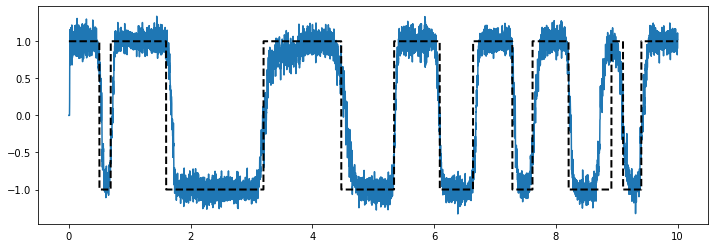

In [31]:
plt.figure(figsize=(12,4))
filt = nengo.synapses.Lowpass(0.01)
plt.plot(sim.trange(), filt.filt(sim.data[p_output]))

ideal = np.where(sim.data[p_stim_a][:,0]*sim.data[p_stim_a][:,1]>sim.data[p_stim_b][:,0]*sim.data[p_stim_b][:,1], 1, -1)
plt.plot(sim.trange(), ideal, ls='--', lw=2, c='k')
plt.show()

I hope this shows the basic process for using nengo to simulate some types of neuromorphic hardware!  The next steps would be to add more details, depending on the hardware being simulated.  We can also use this sort of approach to help design the hardware itself, by adjusting parameters in simulation and evaluating how accurate the resulting system is.  This is the approach we used in https://ieeexplore.ieee.org/document/8351459.
